# Problem description

Another type of less traditional data is text.
There is potentially a lot of information about a company in documents such as
- News articles
- Annual/quarterly filings
- Analyst reports
- Blogs

The key element about text is that a document is a *sequence* of words.
In other words, order matters.
Consider
- "Machine Learning is easy not hard"
- "Machine Learning is hard not easy"

Two sentences with identical words but different meaning.

In this assignment we will analyze text in the form of Tweets.
Our objective is: given a tweet about a company, does the tweet indicate Positive sentiment or Negative sentiment.

This assignment will also serve as a preview of Natural Language Processing: the use of Machine Learning to analyze text.
This will be the subject of a later lecture.

Our immediate objective is to use Recurrent Neural Networks to analyze a sequence of words (i.e., a tweet).




## Goal: problem set 1

There are two notebook files in this assignment:
- **`Sentiment_from_tweets.ipynb`**: First and only notebook you need to work on. Train your models and save them
- **`Model_test.ipynb`**: Test your results. After you complete the `Ships_in_satellite_images_P2.ipynb`, this notebook should be submitted


**Before you start working on this assignment, please check if your kernel is Python 3.7 (Right top of the page). If it is not Python 3.7, please go to `Kernel->Change kernel->Python 3.7` on the top**

In this `Sentiment_from_tweets.ipynb` notebook, you will need to create Sequential models in Keras to analyze the sentiment in tweets.
- Each example is a sequence of words
- The labels are integers: high values indicate Positive sentiment, low values indicate Negative sentiment


## Learning objectives
- Learn how to use Recurrent Layer types as part of a Keras Sequential model
- Appreciate how layer choices impact number of weights

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing

import os
import re
import math

%matplotlib inline


## Import tensorflow and check the version of tensorflow
import tensorflow as tf
print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
import IPython


Running TensorFlow version  2.0.0
Version 2, minor 0


# API for students

We will define some utility routines.

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

**If you want to take a look at the API, you can open it by selecting "File->Open->RNN_helper.py"**

`helper = RNN_helper.rnn_helper()`

### Preprocess raw dataset
- getDataRaw: get raw data. 
  >`DIR` is the directory of data     
  >`tweet_file` is the name of data file     
  >`tweets_raw = helper.getDataRaw(DIR, tweet_file)`   
- getTextClean: clean text. 
  >`tweets_raw` is the raw data you get from `helper.getDataRaw()`, which is a pandas DataFrame     
  >`docs, sents = helepr.getTextClean(tweets_raw)`     
- show: display data by reversing index back to word. 
  >`tok` is an object of `Tokenizer`     
  >`encoded_docs_padded` is the text data which you have encoded and padded      
  >`helper.show(tok, encoded_docs_padded)`      
- getExamples: one-hot encode samples. 
  >`encoded_docs_padded` is the text data which you have encoded and padded     
  >`sents` is the labels     
  >`max_features` is number of words in the vocabulary    
  >`X, y = helper.getExamples(encoded_docs_padded, sents, max_features)`
  
### Save model and load model
- save model (portable): save a model in `./models` directory
  >`helper.saveModel(model, modelName)`
- save history (non-portable): save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
- save model (portable): save a model in `./models` directory
  >`helper.saveModel(model, modelName)`
- save history (non-portable): save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`

### Plot models and training results
- plotModel: plot your models
  >`plotModel(model, model_name)`
- plot_training: plot your training results
  >`plot_training(history, metric='acc)`

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

import RNN_helper
%aimport RNN_helper

helper = RNN_helper.rnn_helper()

## Get the tweets (as text)

In [3]:
# Directory and file name
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/tweets/Data"

tweet_file = "Apple-Twitter-Sentiment-DFE-1.csv"

# Load raw data
tweets_raw = helper.getDataRaw(DATA_DIR, tweet_file)
tweets_raw[ ["text", "sentiment"] ].head(10)

print("Sentiment values (raw)", np.unique(tweets_raw["sentiment"]))

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3
5,#AAPL:5 Rocket Stocks to Buy for December Gain...,3
6,Top 3 all @Apple #tablets. Damn right! http://...,5
7,CNBCTV: #Apple's margins better than expected?...,5
8,Apple Inc. Flash Crash: What You Need to Know ...,3
9,#AAPL:This Presentation Shows What Makes The W...,3


Sentiment values (raw) ['1' '3' '5' 'not_relevant']


## Data preprocessing

There will be a number of preprocessing steps necessary to convert the raw tweets to a form
amenable to a Neural Network.

The next few cells will take you through the journey from **"raw" data** to the **X** (array of examples)
and **y** (array of labels for each example) arrays that you will need for your Neural Network.

In an academic setting you will often be given X and y.
This will rarely be the case in the real world.

So although this journey has little to do with our objective in learning about Recurrent Neural Networks,
we encourage you to follow along.

If you are anxious to get to the Recurrent Neural Network part: you can defer the journey until later
and skip to the cell that defines X and y.

As you can see, tweets have their own special notation that distinguishes it from ordinary language
- "Mentions" begin with "@" and refer to another user: "@kenperry"
- "Hash tags" begin with "#" and refer to a subject: #MachineLearning

This means that our vocabulary (set of distinct words) can be huge.  To manage the vocabulary size
and simplify the problem (perhaps losing information on the way), we will **not** distinguish between
individual mentions and hash tags

Let's also examine the possible sentiment values
- There is a "not_relevant" value; we should eliminate these examples
- The sentiment value is a string
- The strings represent non-consecutive integers

There is quite a bit of cleaning of the raw data necessary; fortunately, we will do that for you below. We will use `helper.getTextClean()` here

In [4]:
docs, sents = helper.getTextClean(tweets_raw)

print("Docs shape is ", docs.shape)
print("Sents shape is ", sents.shape)

print("Possible sentiment values: ",  np.unique(sents) ) 


Docs shape is  (3804,)
Sents shape is  (3804,)
Possible sentiment values:  [0 1 2]


## More data preprocessing

Great, our text is in much better shape and our sentiment (target value for prediction) are now consecutive values.

But computers handle numbers much more readily than strings.
We will need to convert the text in a *sequence* of numbers
- Break text up into words
- Assign each word a distinct integer

Moreover, it will be easier if all sequences have the same length.
We can add a "padding" character to the front if necessary.

Again, we do this for you below.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

## set parameters
# max_features: number of words in the vocabulary (and hence, the length of the One Hot Encoding feature vector)
# maxlen: number of words in a review
max_features = 1000
maxlen = 40

## Tokenize text
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(docs)

encoded_docs = tok.texts_to_sequences(docs)
# The length of different sequence samples may be different, so we use padding method to make them have same length
encoded_docs_padded = sequence.pad_sequences(encoded_docs, maxlen=maxlen)

encoded_docs_padded[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   4,   3, 204, 136,  93, 109, 356, 253,
          2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          8,   1,  43,   4, 123, 141,  11, 230, 537, 454, 168,   4,   4,
          2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  15, 182,   1, 805, 581,
         60],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  13,  48,  36,   1,
         40,   3, 156, 212,  49, 153,   6,   4,  85,  55,   7, 157,   5,
        231],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 

## Verify that our encoded documents are the same as the cleaned original

At this point: convince yourself that all we have done was encode words as integers and pad out all text to the same length.  

The following will demonstrate this. We will use `helper.show()` here

In [6]:
helper.show(tok, encoded_docs_padded)

0:	aapl the 10 best steve jobs emails ever link
1:	rt mention why aapl stock had a mini flash crash today aapl aapl link
2:	my only mention cords such an
3:	i agree with mention that the should own not trade apple aapl it's so is good to see
4:	the aapl


## Even more preprocessing

Although a word has been encoded as an integer, this integer doesn't have a particular meaning.

We will therefore convert each word to a One Hot Encoded (OHE) vector
- The length of the vector is equal to the length of the vocabulary (set of distinct words)
- The vector is all 0 except for a single location which will be 1
- If the word is the $k^{th}$ word of the vocabulary, the position of the sole 1 will be $k$

This representation is called One Hot Encoding
- A word as a feature vector of length $V$, where $V$ is the number of words in the vocabulary
    - Feature $j$ is a binary indicator which is true if the word is the $j^{th}$ word in the vocabulary
    
Finally: we can get the set of examples and associated labels in a form ready for processing by
the Neural Network.

At this point, they will be hard to recognize by a human being. We will use `helper.getExamples()` here

In [7]:
X, y = helper.getExamples(encoded_docs_padded, sents, max_features)
print(X[:5])

[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [8]:
# save X and y for further testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/dataset.npz', X = X, y = y)

## A note on the representation of words as OHE vectors

There are *much better* representations of words than as OHE vectors !

We will learn about this in our lecture on Natural Language Processing.

For now, the OHE representation will suffice.

# Split the data into test and training sets


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# How long is the sequence in a *single* example

**Question:**

Compute the length and number of features of a sequence

Set the following variables to values as described in the cell below
- `example_sequence_len`
- `example_num_features`

In [10]:
# Set two variables
# example_sequence_len: length of the sequence
# example_num_features: number of features in a single element of the sequence (of a single example)

### BEGIN SOLUTION
example_shape = X.shape[1:]
example_sequence_len, example_num_features = example_shape[0], example_shape[1]
### END SOLUTION

print('The length of a sequence is ', example_sequence_len)
print('Number of features is ', example_num_features)

The length of a sequence is  40
Number of features is  1000


Hopefully, you answered the question by examining the examples.

For comparison: the cell in the "More data preprocessing" section defined
- `maxlen`: the maximum sequence length allowed
- `max_features`: the maximum number of features allowed (i.e., vocabulary size)



In [11]:
print("Maximum sequence length: {l:d}".format(l=maxlen))
print("Vocabulary size: {s:d}".format(s=max_features))

Maximum sequence length: 40
Vocabulary size: 1000


# Part 1: Create a Keras Sequential model using a Recurrent layer type

You will create a model that
- takes as input: a sequence of one hot encodings of words (i.e., a representation of a tweet)
- predicts (outputs) a sentiment

**Note**
You should treat the sentiment as a Categorical (discrete) value, rather than a continous one
- As we saw: the sentiment label values are not continuous
- We cannot really assign a "magnitude" to the sentiment
    - We cannot say that a sentiment of 5 is five times "higher" than a sentiment of 1
- We will thus treat the problem as one of Classification rather than Regression
- **We have not one hot encoded the labels** (i.e., the sents variable). 

## Create model 

**Question:** Build a very basic model with two layers
- A Recurrent layer (LSTM to be specific) with a hidden state size of 128, name it "lstm_1"
- A Head layer implementing multinomial Classification, name it "dense_head"

**Hint:**
Since this is a multinomial problem, you need to use `softmax` function for your head layer

In [12]:
model_lstm = None

### BEGIN SOLUTION
model_lstm = Sequential( [LSTM(128, input_shape=X.shape[-2:], name='lstm_1'),
                          Dense( len( np.unique(y)), name='dense_head', activation="softmax")
                         ]
                       )

### END SOLUTION

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               578048    
_________________________________________________________________
dense_head (Dense)           (None, 3)                 387       
Total params: 578,435
Trainable params: 578,435
Non-trainable params: 0
_________________________________________________________________


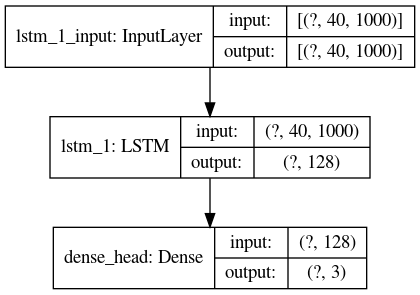

In [13]:
# Plot your model
plot_lstm = helper.plotModel(model_lstm, "lstm")
IPython.display.Image(plot_lstm) 

## Train model

**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 90% will be used for training the model
    - 10% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: `sparse_categorical_crossentropy`; Metric: "accuracy"
- Use exactly 15  epochs for training
- Save your training results in a variable named `history1`
- Plot your training results using API `helper.plot_training()`

**Loss functions:**  `sparse_categorical_crossentropy` versus `categorical_crossentropy` 
- `categorical_crossentropy` computes Cross Entropy loss when targets are One Hot Encoded
- `sparse_categorical_crossentropy` computes Cross Entropy loss when targets are consecutive integers
- We have **not** used OHE for our labels here, so don't use `categorical_crossentropy`
- Alternatively, you can encode the labels using `to_categorical()` and use `categorical_crossentropy`

Train on 3080 samples, validate on 343 samples
Epoch 1/15
3080/3080 [==============================] - 11s 4ms/sample - loss: 0.8662 - acc: 0.6107 - val_loss: 0.7723 - val_acc: 0.7172
Epoch 2/15
3080/3080 [==============================] - 6s 2ms/sample - loss: 0.7059 - acc: 0.7289 - val_loss: 1.8320 - val_acc: 0.5044
Epoch 3/15
3080/3080 [==============================] - 9s 3ms/sample - loss: 0.6327 - acc: 0.7597 - val_loss: 0.6810 - val_acc: 0.7376
Epoch 4/15
3080/3080 [==============================] - 8s 2ms/sample - loss: 0.5565 - acc: 0.7838 - val_loss: 0.7224 - val_acc: 0.7522
Epoch 5/15
3080/3080 [==============================] - 6s 2ms/sample - loss: 0.5090 - acc: 0.8019 - val_loss: 0.6905 - val_acc: 0.7376
Epoch 6/15
3080/3080 [==============================] - 6s 2ms/sample - loss: 0.4787 - acc: 0.8146 - val_loss: 0.6912 - val_acc: 0.7551
Epoch 7/15
3080/3080 [==============================] - 6s 2ms/sample - loss: 0.4528 - acc: 0.8286 - val_loss: 0.7634 - val_acc: 0.7493


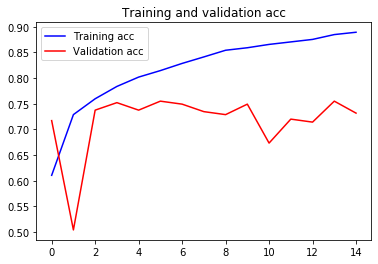

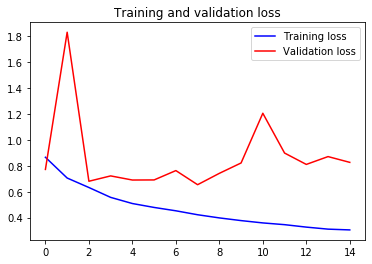

In [14]:
# Set parameters
model_name_1 = 'LSTM_sparsecat'
num_epochs = 15

# If you don't use one-hot encoded labels
loss_ = 'sparse_categorical_crossentropy'
metric = 'acc'

### BEGIN SOLUTION
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
model_lstm.compile(loss=loss_,
            metrics=[metric]
            )

history1 = model_lstm.fit(X_train_, y_train_,
    epochs=num_epochs,
    validation_data=(X_val_, y_val_))

# Plot training result
helper.plot_training(history1)
### END SOLUTION

**Expected outputs (there may be some differences):**  
<table> 
    <tr> 
        <td>  
            Training accuracy
        </td>
        <td>
         0.9120
        </td>
    </tr>
    <tr> 
        <td>
            Validation accuracy
        </td>
        <td>
         0.7259
        </td>
    </tr>

</table>

The loss and accuracy graphs of first model are similiar to this:
<img src="https://github.com/nyutandononline/MachineLearning_and_Finance_Teacher/blob/master/Assignment_DL_teacher/DL_3_sentiment_from_tweets/images/model1_acc.png?raw=1" style="width:600px;height:300px;">
<img src="https://github.com/nyutandononline/MachineLearning_and_Finance_Teacher/blob/master/Assignment_DL_teacher/DL_3_sentiment_from_tweets/images/model1_loss.png?raw=1" style="width:600px;height:300px;">

We can see that the out of sample loss does not improve, even as in sample loss does.
This might mean that we have an overfitting problem.


## Evalutate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score1`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.



In [15]:
socre1 = None

### BEGIN SOLUTION
score1 = model_lstm.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name_1, l=score1[0], a=score1[1]))

LSTM_sparsecat: Test loss: 0.90 / Test accuracy: 0.72


## Save the trained model_lstm and history1 for submission

In [16]:
helper.saveModel(model_lstm, model_name_1)
helper.saveHistory(history1, model_name_1)

Model saved in directory ./models/LSTM_sparsecat; create an archive of this directory and submit with your assignment.
Directory ./models/LSTM_sparsecat already exists, files will be over-written.


## Let's check the number of our models, how many weights in your recurrent model?

How many weights in your model?

You should always be sensitive to how "big" your model is.

In [17]:
# Set variable
# - num_weights_lstm: number of weights in your model
num_weights_lstm = 0

### BEGIN SOLUTION
num_weights_lstm = model_lstm.count_params()
### END SOLUTION

print("number of parameters is ", num_weights_lstm)

number of parameters is  578435


# Part 2: Create a model consisting only of a Classification head

The Recurrent layer type creates a fixed length (i.e., size of hidden state) encoding of a variable length input sequence
- No matter how long the input, the encoding will have fixed length

But it needs quite a few parameters, and seems to have a overfitting problem.

Let's compare this to a simple Classifier only model
- That reduces the sequence to a single feature vector
    - Length of the single feature vector is the same as any element of the sequence
- There are a couple of ways to do this
    - Take the sum or average (across the sequence) of each feature
    - Take the max (across the sequence) of each feature

**Question:** 

Create a Keras Sequential model
- Using only two layers:
    - 1 pooling layer
    - A Classification head
        - Name your head layer "dense_head"
    
The pooling layer should reduce your variable length sequence to a fixed length.
- That's what the RNN layer of the previous model did, although in a more complex manner.

A fixed length input is what the Classification head needs.

**Hint:**
- Investigate the Keras `GlobalMaxPooling1D` and `GlobalAveragePooling1D` layer types

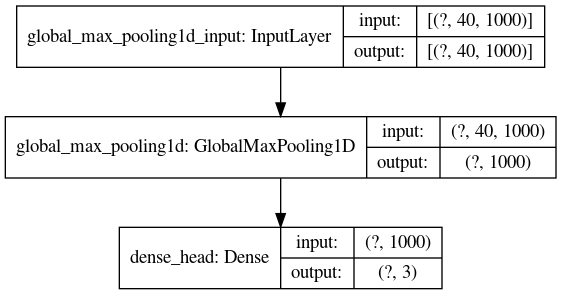

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling1d (Global (None, 1000)              0         
_________________________________________________________________
dense_head (Dense)           (None, 3)                 3003      
Total params: 3,003
Trainable params: 3,003
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_simple = None

### BEGIN SOLUTION
model_simple = Sequential( [ GlobalMaxPooling1D(input_shape=X_train.shape[-2:]),
                             Dense( len( np.unique(y) ), activation="softmax", name='dense_head')
                           ]
                         )

### END SOLUTION

# Plot model
plot_simple = helper.plotModel(model_simple, "simple")
IPython.display.Image(plot_simple) 

model_simple.summary()

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- **Except**: Save your training results in a variable named `history2`
- Name your model "Only_head"




Train on 3080 samples, validate on 343 samples
Epoch 1/15
3080/3080 [==============================] - 1s 303us/sample - loss: 0.9355 - acc: 0.5971 - val_loss: 0.8339 - val_acc: 0.6851
Epoch 2/15
3080/3080 [==============================] - 1s 214us/sample - loss: 0.8023 - acc: 0.6951 - val_loss: 0.7533 - val_acc: 0.7172
Epoch 3/15
3080/3080 [==============================] - 1s 181us/sample - loss: 0.7410 - acc: 0.7153 - val_loss: 0.7088 - val_acc: 0.7434
Epoch 4/15
3080/3080 [==============================] - 1s 172us/sample - loss: 0.7029 - acc: 0.7266 - val_loss: 0.6842 - val_acc: 0.7405
Epoch 5/15
3080/3080 [==============================] - 1s 185us/sample - loss: 0.6752 - acc: 0.7312 - val_loss: 0.6655 - val_acc: 0.7434
Epoch 6/15
3080/3080 [==============================] - 1s 178us/sample - loss: 0.6533 - acc: 0.7393 - val_loss: 0.6513 - val_acc: 0.7464
Epoch 7/15
3080/3080 [==============================] - 1s 180us/sample - loss: 0.6349 - acc: 0.7461 - val_loss: 0.6418 - val

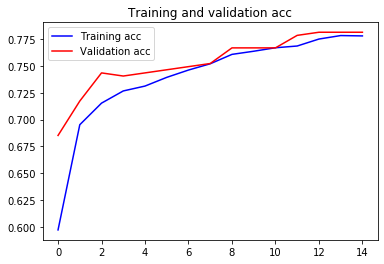

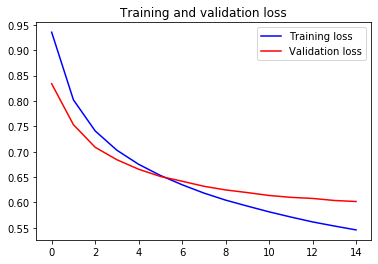

In [19]:
# Set parameters
model_name_2 = 'Only_head'
num_epochs = 15
metric = 'acc'
loss_ = 'sparse_categorical_crossentropy'


### BEGIN SOLUTION
# X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
model_simple.compile(loss= loss_,
            metrics=[metric]
            )

history2 = model_simple.fit(X_train_, y_train_,
    epochs=num_epochs,
    validation_data=(X_val_, y_val_))

# Plot training result
helper.plot_training(history2)
### END SOLUTION

**Expected outputs (there may be some differences):**  
<table> 
    <tr> 
        <td>  
            Training accuracy
        </td>
        <td>
         0.7776
        </td>
    </tr>
    <tr> 
        <td>
            Validation accuracy
        </td>
        <td>
         0.7784
        </td>
    </tr>

</table>

The loss and accuracy graphs of first model are similiar to this:
<img src="https://github.com/nyutandononline/MachineLearning_and_Finance_Teacher/blob/master/Assignment_DL_teacher/DL_3_sentiment_from_tweets/images/model2_acc.png?raw=1" style="width:600px;height:300px;">
<img src="https://github.com/nyutandononline/MachineLearning_and_Finance_Teacher/blob/master/Assignment_DL_teacher/DL_3_sentiment_from_tweets/images/model2_loss.png?raw=1" style="width:600px;height:300px;">

We can see that out of sample and in sample losses are not too different, so it appears that we
are not overfitting, at least until the number of epochs grows.

## Save the trained model_simple and history2 for submission

In [20]:
helper.saveModel(model_simple, model_name_2)
helper.saveHistory(history2, model_name_2)

Model saved in directory ./models/Only_head; create an archive of this directory and submit with your assignment.
Directory ./models/Only_head already exists, files will be over-written.


## How many weights in your Classifier only model ?

How many weights in your model ?

You should always be sensitive to how "big" your model is.

In [21]:
# Set variable
# - num_weights_lstm: number of weights in your model
num_weights_simple = 0

### BEGIN SOLUTION
num_weights_simple = model_simple.count_params()
### END SOLUTION

print("number of parameters is ", num_weights_simple)

number of parameters is  3003


Compared with the previous RNN moddel, we have much **less** parameters, but the validation accuracy is better than RNN model!

# Discussion

- Was the increase in number of weights (when using a Recurrent Layer compared to the Classifier only model) compensated by a gain in accuracy  ?
- Can you speculate why this is so ?

## Now Submit your assignment!
Please click on the blue button <span style="color: blue;"> **Submit** </span> in this notebook. 